In [1]:
!pip install astro-datasets numpy matplotlib albumentations

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import time, sys, os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import astro_datasets
import matplotlib.pyplot as plt
import albumentations as alb

2022-11-21 15:12:56.343207: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
(cmd_train, cmd_test, cmd_val), info = tfds.load(name='cmd', 
                                                 split=['train[0%:90%]','train[90%:95%]','train[95%:100%]'], 
                                                 with_info=True, 
                                                 as_supervised=True, 
                                                 builder_kwargs={'simulation': 'Nbody_IllustrisTNG', 'field': 'Mtot', 
                                                 'parameters': ['sigma8']})

2022-11-21 15:12:59.051088: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 15:12:59.781617: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78935 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:44:00.0, compute capability: 8.0


In [4]:
(simba_train, simba_test, simba_val), info_simba = tfds.load(name='cmd', 
                                                 split=['train[0%:90%]','train[90%:95%]','train[95%:100%]'], 
                                                 with_info=True, 
                                                 as_supervised=True, 
                                                 builder_kwargs={'simulation': 'Nbody_SIMBA', 'field': 'Mtot', 
                                                 'parameters': ['sigma8']})

In [5]:
# define preprocessing, normalization and augmentation functions

def normalize(image, label):  
    image = tf.math.asinh(image)
    image = image - 26
    return image, label

def aug_fn(image):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[256, 256])
    return aug_img

def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image],\
                                Tout=tf.float32)
    return aug_img, label

def set_shapes(img, label, img_shape=(256, 256, 1)):
    img.set_shape(img_shape)
    label.set_shape(1,)
    return img, label

# Define augmentation pipeline

transforms = alb.Compose([alb.VerticalFlip(p=0.6),
                          alb.HorizontalFlip(p=0.6),
                          alb.RandomRotate90(p=0.6)])


In [6]:
btch_size = 128

In [7]:
cmd_train = cmd_train.repeat(count=3) # increase dataset size
cmd_train = cmd_train.map(process_data)
cmd_train = cmd_train.map(set_shapes)
cmd_train = cmd_train.map(normalize)
cmd_train = cmd_train.batch(btch_size).prefetch(tf.data.AUTOTUNE)

cmd_test = cmd_test.map(normalize)
cmd_test = cmd_test.batch(btch_size).prefetch(tf.data.AUTOTUNE)

cmd_val = cmd_val.map(normalize)
cmd_val = cmd_val.batch(btch_size).prefetch(tf.data.AUTOTUNE)

In [8]:
simba_train = simba_train.repeat(count=3) # increase dataset size
simba_train = simba_train.map(process_data)
simba_train = simba_train.map(set_shapes)
simba_train = simba_train.map(normalize)
simba_train = simba_train.batch(btch_size).prefetch(tf.data.AUTOTUNE)

simba_test = simba_test.map(normalize)
simba_test = simba_test.batch(btch_size).prefetch(tf.data.AUTOTUNE)

simba_val = simba_val.map(normalize)
simba_val = simba_val.batch(btch_size).prefetch(tf.data.AUTOTUNE)

In [9]:
H = 7

In [10]:
#design CNN architecture
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(2*H, kernel_size=3, strides=1, padding = 'same', input_shape=(256, 256, 1)),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(2*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(2*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(4*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(4*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(4*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),  
  tf.keras.layers.Conv2D(8*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(8*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(8*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),    
  tf.keras.layers.Conv2D(16*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(16*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(16*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),    
  tf.keras.layers.Conv2D(32*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(32*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(32*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(64*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(64*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(64*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),  
  tf.keras.layers.Conv2D(128*H, kernel_size=4, strides=1, padding = 'valid'),  
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),  
  tf.keras.layers.Flatten(),  
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64*H),
  tf.keras.layers.LeakyReLU(0.2), 
  tf.keras.layers.Dropout(0.2),  
  tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 14)      140       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 14)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 14)      1778      
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 14)     56        
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256, 256, 14)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 14)      798       
                                                        

In [11]:
opt = tf.keras.optimizers.Adam(beta_1=0.5, beta_2=0.999)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10)

In [12]:
#compile model, set the optimiser and the loss as defined above 
model.compile(optimizer=opt,
              loss='mae',
              metrics=['mse'])

In [13]:
epochs = 50

In [14]:
checkpoint_path = "./cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 monitor='val_loss',
                                                 mode='min',
                                                 verbose=1,
                                                 save_best_only=True)

model.fit(simba_train, epochs=epochs, 
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True), reduce_lr, cp_callback], 
          validation_data=simba_val)

Epoch 1/50


2022-11-21 15:13:06.313301: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2022-11-21 15:13:08.273579: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-11-21 15:13:08.276896: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1e055ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-11-21 15:13:08.276939: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2022-11-21 15:13:08.282845: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-11-21 15:13:08.427073: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pr

317/317 [==============================] - ETA: 0s - loss: 0.3138 - mse: 0.5888
Epoch 1: val_loss improved from inf to 2.12671, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 109s 300ms/step - loss: 0.3138 - mse: 0.5888 - val_loss: 2.1267 - val_mse: 14.5520 - lr: 0.0010
Epoch 2/50
317/317 [==============================] - ETA: 0s - loss: 0.1230 - mse: 0.1040
Epoch 2: val_loss improved from 2.12671 to 0.20053, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 94s 297ms/step - loss: 0.1230 - mse: 0.1040 - val_loss: 0.2005 - val_mse: 0.1542 - lr: 0.0010
Epoch 3/50
317/317 [==============================] - ETA: 0s - loss: 0.0825 - mse: 0.0627
Epoch 3: val_loss did not improve from 0.20053
317/317 [==============================] - 86s 271ms/step - loss: 0.0825 - mse: 0.0627 - val_loss: 15.5613 - val_mse: 523.2275 - lr: 0.0010
Epoch 4/50
317/317 [==============================] - ETA: 0s - loss: 0.0707 - mse: 0.0346
Epoch 4: val_loss improved from 0.20053 to 0.10121, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 93s 292ms/step - loss: 0.0707 - mse: 0.0346 - val_loss: 0.1012 - val_mse: 0.0122 - lr: 0.0010
Epoch 5/50
317/317 [==============================] - ETA: 0s - loss: 0.0646 - mse: 0.0256
Epoch 5: val_loss did not improve from 0.10121
317/317 [==============================] - 87s 274ms/step - loss: 0.0646 - mse: 0.0256 - val_loss: 0.1837 - val_mse: 0.0399 - lr: 0.0010
Epoch 6/50
317/317 [==============================] - ETA: 0s - loss: 0.0530 - mse: 0.0158
Epoch 6: val_loss improved from 0.10121 to 0.02711, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 91s 288ms/step - loss: 0.0530 - mse: 0.0158 - val_loss: 0.0271 - val_mse: 0.0013 - lr: 0.0010
Epoch 7/50
317/317 [==============================] - ETA: 0s - loss: 0.0474 - mse: 0.0146
Epoch 7: val_loss did not improve from 0.02711
317/317 [==============================] - 85s 267ms/step - loss: 0.0474 - mse: 0.0146 - val_loss: 0.1300 - val_mse: 0.0324 - lr: 0.0010
Epoch 8/50
317/317 [==============================] - ETA: 0s - loss: 0.0482 - mse: 0.0133
Epoch 8: val_loss did not improve from 0.02711
317/317 [==============================] - 86s 271ms/step - loss: 0.0482 - mse: 0.0133 - val_loss: 0.1771 - val_mse: 0.0414 - lr: 0.0010
Epoch 9/50
317/317 [==============================] - ETA: 0s - loss: 0.0435 - mse: 0.0101
Epoch 9: val_loss did not improve from 0.02711
317/317 [==============================] - 88s 277ms/step - loss: 0.0435 - mse: 0.0101 - val_loss: 0.2034 - val_mse: 0.1521 - lr: 0.0010
Epoch 10/50
317/317 [=================

INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 91s 288ms/step - loss: 0.0260 - mse: 0.0022 - val_loss: 0.0215 - val_mse: 7.5501e-04 - lr: 3.0000e-04
Epoch 18/50
317/317 [==============================] - ETA: 0s - loss: 0.0254 - mse: 0.0022
Epoch 18: val_loss did not improve from 0.02154
317/317 [==============================] - 85s 269ms/step - loss: 0.0254 - mse: 0.0022 - val_loss: 0.0335 - val_mse: 0.0016 - lr: 3.0000e-04
Epoch 19/50
317/317 [==============================] - ETA: 0s - loss: 0.0246 - mse: 0.0020
Epoch 19: val_loss did not improve from 0.02154
317/317 [==============================] - 88s 276ms/step - loss: 0.0246 - mse: 0.0020 - val_loss: 0.2142 - val_mse: 0.2030 - lr: 3.0000e-04
Epoch 20/50
317/317 [==============================] - ETA: 0s - loss: 0.0245 - mse: 0.0021
Epoch 20: val_loss did not improve from 0.02154
317/317 [==============================] - 85s 269ms/step - loss: 0.0245 - mse: 0.0021 - val_loss: 0.0624 - val_mse: 0.0633 - lr: 3.0000e-04
Epoch 21/50


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 93s 293ms/step - loss: 0.0206 - mse: 9.9337e-04 - val_loss: 0.0209 - val_mse: 7.3601e-04 - lr: 9.0000e-05
Epoch 31/50
317/317 [==============================] - ETA: 0s - loss: 0.0204 - mse: 9.5654e-04
Epoch 31: val_loss did not improve from 0.02091
317/317 [==============================] - 86s 271ms/step - loss: 0.0204 - mse: 9.5654e-04 - val_loss: 0.0400 - val_mse: 0.0040 - lr: 9.0000e-05
Epoch 32/50
317/317 [==============================] - ETA: 0s - loss: 0.0203 - mse: 9.2553e-04
Epoch 32: val_loss did not improve from 0.02091
317/317 [==============================] - 86s 271ms/step - loss: 0.0203 - mse: 9.2553e-04 - val_loss: 0.0392 - val_mse: 0.0053 - lr: 9.0000e-05
Epoch 33/50
317/317 [==============================] - ETA: 0s - loss: 0.0198 - mse: 8.3745e-04
Epoch 33: val_loss did not improve from 0.02091
317/317 [==============================] - 86s 270ms/step - loss: 0.0198 - mse: 8.3745e-04 - val_loss: 0.0365 - val_mse: 0.0042 -

INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 91s 287ms/step - loss: 0.0199 - mse: 9.2727e-04 - val_loss: 0.0205 - val_mse: 6.2631e-04 - lr: 9.0000e-05
Epoch 36/50
317/317 [==============================] - ETA: 0s - loss: 0.0200 - mse: 9.9135e-04
Epoch 36: val_loss did not improve from 0.02048
317/317 [==============================] - 86s 271ms/step - loss: 0.0200 - mse: 9.9135e-04 - val_loss: 0.0276 - val_mse: 0.0014 - lr: 9.0000e-05
Epoch 37/50
317/317 [==============================] - ETA: 0s - loss: 0.0197 - mse: 9.1966e-04
Epoch 37: val_loss did not improve from 0.02048
317/317 [==============================] - 86s 271ms/step - loss: 0.0197 - mse: 9.1966e-04 - val_loss: 0.0237 - val_mse: 7.9401e-04 - lr: 9.0000e-05
Epoch 38/50
317/317 [==============================] - ETA: 0s - loss: 0.0197 - mse: 8.8350e-04
Epoch 38: val_loss did not improve from 0.02048
317/317 [==============================] - 86s 270ms/step - loss: 0.0197 - mse: 8.8350e-04 - val_loss: 0.0231 - val_mse: 0.00

INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 92s 292ms/step - loss: 0.0194 - mse: 8.6950e-04 - val_loss: 0.0140 - val_mse: 3.2116e-04 - lr: 9.0000e-05
Epoch 41/50
317/317 [==============================] - ETA: 0s - loss: 0.0194 - mse: 8.5141e-04
Epoch 41: val_loss did not improve from 0.01404
317/317 [==============================] - 85s 269ms/step - loss: 0.0194 - mse: 8.5141e-04 - val_loss: 0.0391 - val_mse: 0.0066 - lr: 9.0000e-05
Epoch 42/50
317/317 [==============================] - ETA: 0s - loss: 0.0193 - mse: 8.6228e-04
Epoch 42: val_loss did not improve from 0.01404
317/317 [==============================] - 85s 269ms/step - loss: 0.0193 - mse: 8.6228e-04 - val_loss: 0.0208 - val_mse: 8.4188e-04 - lr: 9.0000e-05
Epoch 43/50
317/317 [==============================] - ETA: 0s - loss: 0.0192 - mse: 8.3455e-04
Epoch 43: val_loss did not improve from 0.01404
317/317 [==============================] - 85s 269ms/step - loss: 0.0192 - mse: 8.3455e-04 - val_loss: 0.0752 - val_mse: 0.00

In [15]:
best_model = tf.keras.models.load_model(checkpoint_path)

In [16]:
best_model.evaluate(cmd_test)

6/6 [==============================] - 1s 29ms/step - loss: 0.0153 - mse: 0.0013


[0.015267515555024147, 0.0012792876223102212]

In [17]:
best_model.evaluate(simba_test)

6/6 [==============================] - 0s 29ms/step - loss: 0.0159 - mse: 0.0013


[0.01587974838912487, 0.001267045270651579]

In [18]:
yhat_cmd = best_model.predict(cmd_test)

6/6 [==============================] - 1s 25ms/step


In [19]:
yhat_simba = best_model.predict(simba_test)

6/6 [==============================] - 0s 23ms/step


In [20]:
lbl_cmd = np.concatenate([y for x, y in cmd_test], axis=0)

In [21]:
lbl_simba = np.concatenate([y for x, y in simba_test], axis=0)

In [22]:
yhat_cmd.shape

(750, 1)

In [23]:
lbl_cmd.shape

(750, 1)

In [24]:
np.mean(np.abs((lbl_cmd - yhat_cmd) / lbl_cmd))

0.01967454

In [25]:
np.mean(np.abs((lbl_simba - yhat_simba) / lbl_simba))

0.020358203

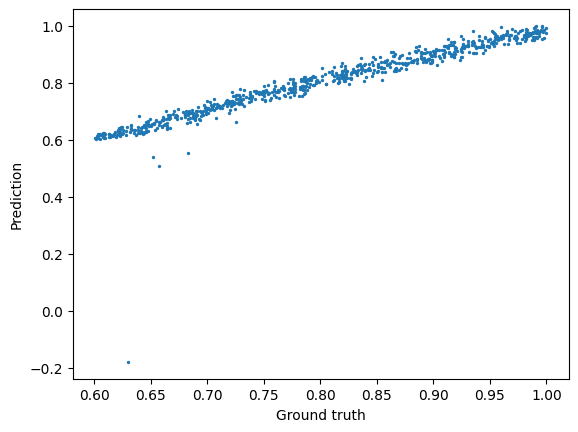

In [26]:
plt.scatter(lbl_simba, yhat_simba, s=2)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

plt.show()